
# Neural Transfer Using PyTorch


## Importing Packages and Selecting a Device

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

# ADDITIONAL EDIT
import os
from os import listdir
from PIL import Image
import glob

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.set_default_device(device)

In [3]:
if torch.cuda.is_available(): 
    print("cuda available")
else:
    print("cuda unavailable")


cuda available


## Loading the Images


In [18]:
# desired size of the output image
imsize = 128

loader = transforms.Compose([
    transforms.Resize(imsize),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

style_img = image_loader("StyleImages/styleImg_1.png")
content_img = image_loader("ContentImages/20230917_144751.jpg")
print(style_img.size())
print(content_img.size())
assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"




torch.Size([1, 3, 128, 227])
torch.Size([1, 3, 128, 227])


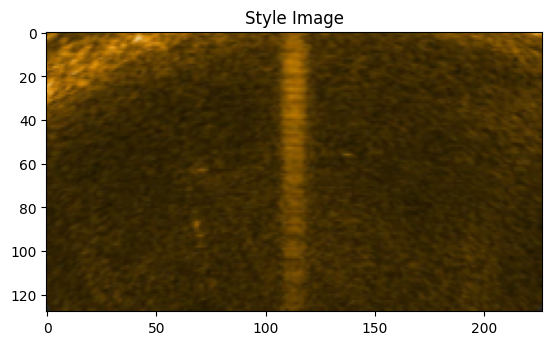

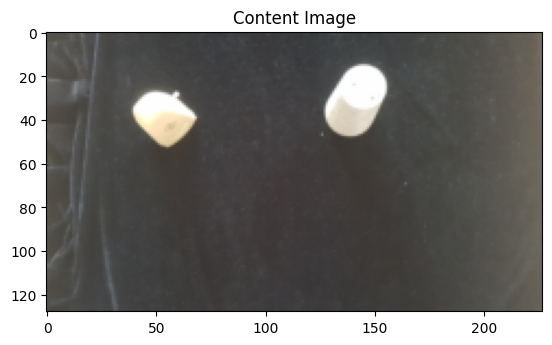

In [6]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

plt.ion()

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated


plt.figure()
imshow(style_img, title='Style Image')

plt.figure()
imshow(content_img, title='Content Image')

## Loss Functions



### Content Loss



In [7]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

### Style Loss




In [8]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resize F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

Now the style loss module looks almost exactly like the content loss
module. The style distance is also computed using the mean square
error between $G_{XL}$ and $G_{SL}$.




In [9]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input

## Importing the Model



In [10]:
cnn = models.vgg19(pretrained=True).features.eval()

C:\Users\TAS-CRC\anaconda3\envs\neuralStyleTransfer\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\TAS-CRC\anaconda3\envs\neuralStyleTransfer\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [11]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406])
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225])

# create a module to normalize input image so we can easily put it in a
# ``nn.Sequential``
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize ``img``
        return (img - self.mean) / self.std

In [12]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    # normalization module
    normalization = Normalization(normalization_mean, normalization_std)

    # just in order to have an iterable access to or list of content/style
    # losses
    content_losses = []
    style_losses = []

    # assuming that ``cnn`` is a ``nn.Sequential``, so we make a new ``nn.Sequential``
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ``ContentLoss``
            # and ``StyleLoss`` we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

## Gradient Descent


In [13]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img])
    return optimizer

In [19]:

def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=400,
                       style_weight=1300000, content_weight=5): # specify the weights and number of steps here

    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)

    # We want to optimize the input and not the model parameters so we
    # update all the requires_grad fields accordingly
    input_img.requires_grad_(True)
    # We also put the model in evaluation mode, so that specific layers 
    # such as dropout or batch normalization layers behave correctly. 
    model.eval()
    model.requires_grad_(False)

    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            with torch.no_grad():
                input_img.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    with torch.no_grad():
        input_img.clamp_(0, 1)

    return input_img

# Run Neural Style Transfer on All Images



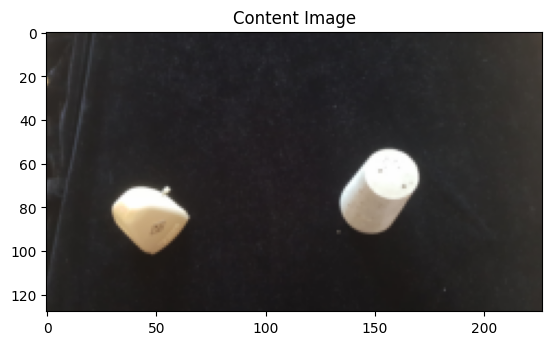

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 34.815575 Content Loss: 50.262794

run [100]:
Style Loss : 12.073042 Content Loss: 38.538105

run [150]:
Style Loss : 7.171167 Content Loss: 35.279007

run [200]:
Style Loss : 4.556137 Content Loss: 33.760769

run [250]:
Style Loss : 3.482574 Content Loss: 32.633625

run [300]:
Style Loss : 3.026152 Content Loss: 31.558594

run [350]:
Style Loss : 2.954781 Content Loss: 30.635683

run [400]:
Style Loss : 2.791291 Content Loss: 30.303782



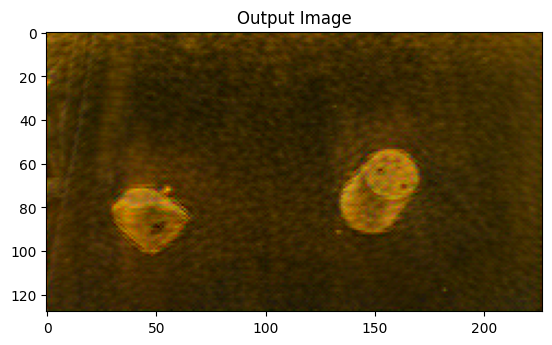

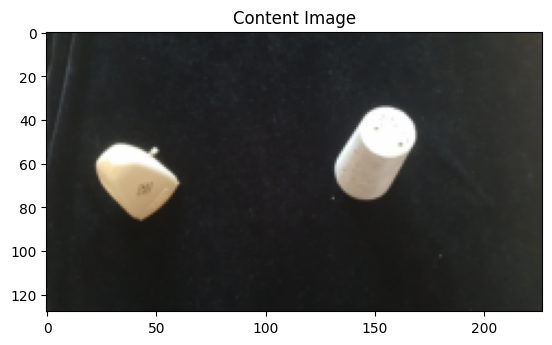

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 37.420208 Content Loss: 51.673927

run [100]:
Style Loss : 13.687875 Content Loss: 41.048508

run [150]:
Style Loss : 8.572232 Content Loss: 37.355656

run [200]:
Style Loss : 5.278767 Content Loss: 35.973896

run [250]:
Style Loss : 3.780811 Content Loss: 34.486336

run [300]:
Style Loss : 3.268007 Content Loss: 33.137222

run [350]:
Style Loss : 3.058025 Content Loss: 32.164543

run [400]:
Style Loss : 2.922408 Content Loss: 31.588741



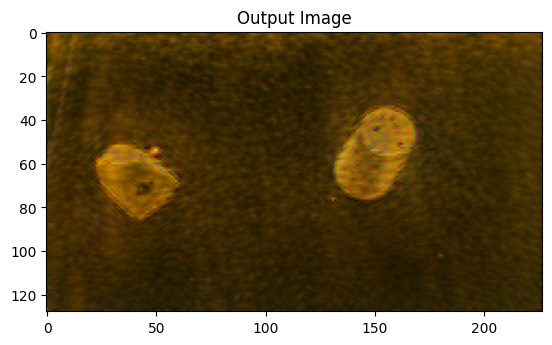

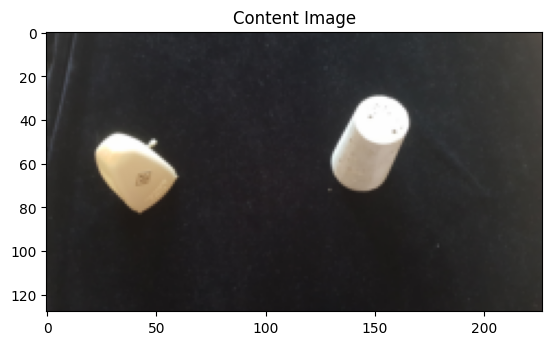

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 43.801399 Content Loss: 52.684891

run [100]:
Style Loss : 16.197931 Content Loss: 41.099606

run [150]:
Style Loss : 9.253685 Content Loss: 37.305367

run [200]:
Style Loss : 5.540817 Content Loss: 35.841812

run [250]:
Style Loss : 3.777014 Content Loss: 34.339012

run [300]:
Style Loss : 3.317714 Content Loss: 32.538448

run [350]:
Style Loss : 3.074143 Content Loss: 31.583803

run [400]:
Style Loss : 3.126589 Content Loss: 31.069403



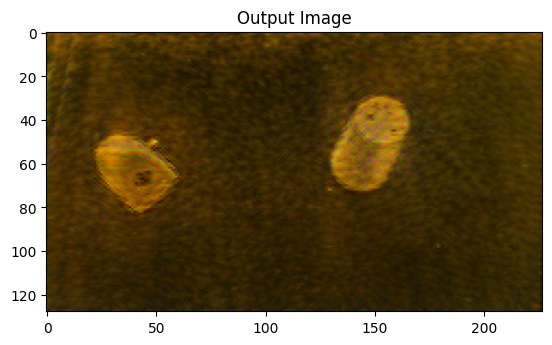

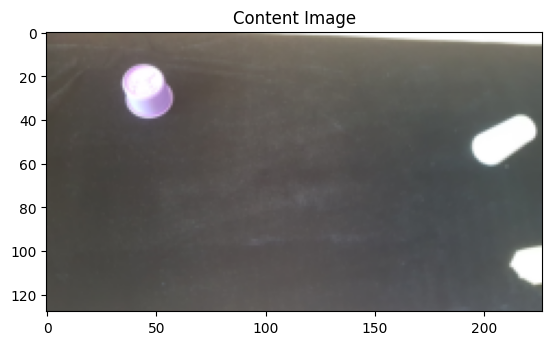

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 359.937958 Content Loss: 57.129089

run [100]:
Style Loss : 128.856781 Content Loss: 51.146790

run [150]:
Style Loss : 55.706825 Content Loss: 52.101101

run [200]:
Style Loss : 14.082145 Content Loss: 56.327023

run [250]:
Style Loss : 5.141169 Content Loss: 44.249611

run [300]:
Style Loss : 3.642885 Content Loss: 39.555977

run [350]:
Style Loss : 2.998911 Content Loss: 36.788994

run [400]:
Style Loss : 2.792248 Content Loss: 35.170235



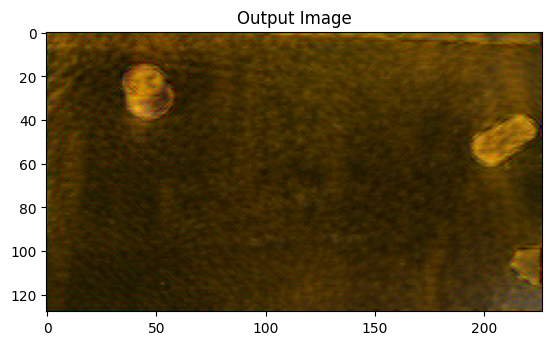

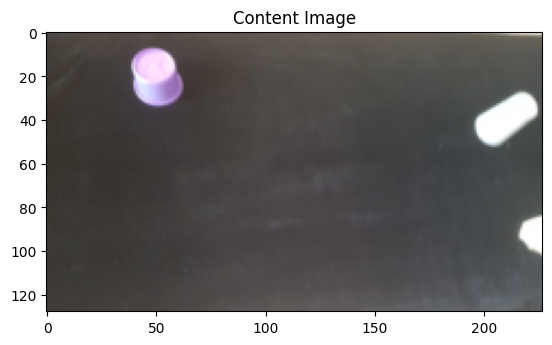

Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 737.340820 Content Loss: 64.388580

run [100]:
Style Loss : 338.051086 Content Loss: 57.169525

run [150]:
Style Loss : 86.121796 Content Loss: 54.399529

run [200]:
Style Loss : 27.720869 Content Loss: 51.026405

run [250]:
Style Loss : 7.130096 Content Loss: 43.109509

run [300]:
Style Loss : 4.779917 Content Loss: 39.141651

run [350]:
Style Loss : 3.656782 Content Loss: 37.401955

run [400]:
Style Loss : 2.995847 Content Loss: 36.361050



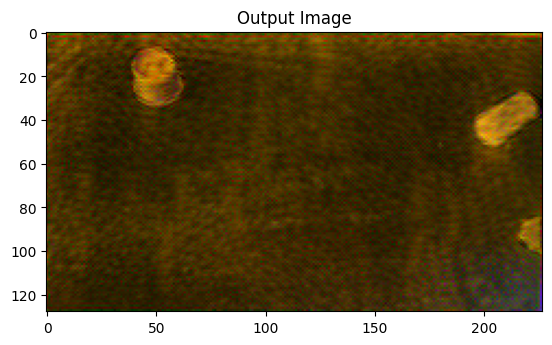

In [20]:
i=0

# Specify the directory path where your images are located
directory_path = "ContentImages"
# Define the file extensions for the images you want to extract
image_extensions = ['*.jpg', '*.png']

# Use glob to get a list of image file paths in the directory
image_files = []
for ext in image_extensions:
    image_files.extend(glob.glob(directory_path + '\\' + ext))  # Use '\\' for Windows paths
    
    
for images in image_files:  
    # load images in directory and convert them to tensors
    content = image_loader(images)
    content_img = content[:, 0:3, :, :]
    
    plt.figure()
    imshow(content_img, title='Content Image')
    
    # ensure the style image and the content image are the same size
    assert style_img.size() == content_img.size(), \
        "we need to import style and content images of the same size"
    input_img = content_img.clone()
    
        
    
    # Style Transfer
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    
    
    # Show the new image
    plt.figure()
    imshow(output, title='Output Image')

    # sphinx_gallery_thumbnail_number = 4
    plt.ioff()
    plt.show()
    
    
    # Create a directory path where you want to save the image
    save_directory = "SyntheticImages"
    
    # Define a transform to convert the tensor to a PIL image
    to_pil_image = transforms.ToPILImage()
    
    # Convert the tensor to a PIL image
    pil_image = to_pil_image(output[0])
    
    # Specify the file path for saving the image
    file_name = str(i) + "_output.png"
    file_path = save_directory + file_name  # Use 'r' before the string to treat it as a raw string

    # Save the PIL image to the specified directory
    pil_image.save(file_path)


    i=i+1

